# Alternative Risk Analysis Methods

### Performance against the sector 
The sector is represented by an appropriate ETF index 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import pandas as pd
import json
from urllib.request import Request, urlopen
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,4)})

In [21]:
def guru_prices(stock):
    subject='price'
    api_key = '73142da8657cc5dfa541b546d1560131:4886c27790bc76bd5e076340a403ade5'
    url = 'https://api.gurufocus.com/public/user/%s/stock/%s/%s' % (api_key, stock, subject)
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    response = urlopen(req)
    content = response.read()
    data = json.loads(content.decode('utf8'))
    return data

In [22]:
data = guru_prices('XSD')
daily_sector = pd.DataFrame(data, columns=(['Date', 'Close']))
daily_sector.set_index('Date', inplace=True)
daily_sector = daily_sector.astype(float)
daily_sector.head()

,Close
Date,
02-06-2006,25.08
02-07-2006,25.19
02-08-2006,25.67
02-09-2006,25.52
02-10-2006,25.35


In [23]:
def guru2pd (ticker):
    col_name = ticker + ' Close'
    data = guru_prices(ticker)
    ts = pd.DataFrame(data, columns=(['Date', col_name]))
    dates = pd.to_datetime(ts['Date'],format='%m-%d-%Y')
    ts['Date'] = dates
    ts.set_index('Date', inplace=True)
    ts[col_name] = ts[col_name].astype(float)
    return ts

In [24]:
tsm = guru2pd('TSM')
sector = guru2pd('SOXX')

In [25]:
tsm['Sector'] = sector

In [26]:
tsm.dropna(inplace=True)
tsm.count()

TSM Close    4622
Sector       4622
dtype: int64

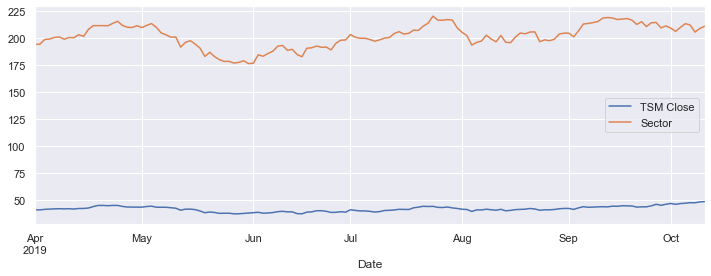

In [27]:
tsm_=tsm['20190401':]
tsm_.plot(y=['TSM Close', 'Sector']);

In [28]:
start='1601'
period = tsm['20%s01'%start:]
delta = period.iloc[0]['TSM Close'] - period.iloc[0]['Sector']
period['Sector'] = period['Sector'] + delta 

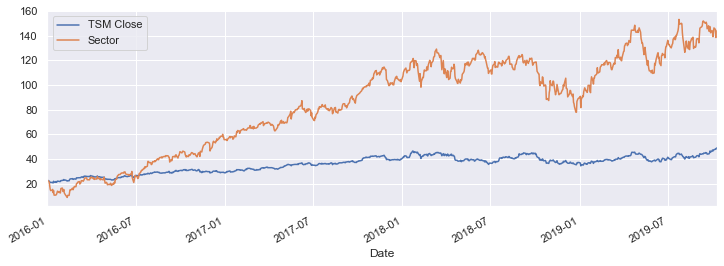

In [29]:
period.plot(y=['TSM Close', 'Sector']);

### Stop Loss alert
Lower limit smart below the 20d/80d moving averages

In [38]:
period['tsm10'] = period.rolling("10d").mean()['TSM Close']
period['tsm20'] = period.rolling("20d").mean()['TSM Close']
period['tsm50'] = period.rolling("50d").mean()['TSM Close']
period['tsm80'] = period.rolling("80d").mean()['TSM Close']
period['stop80'] = period['tsm80'] * 0.95
period['stop20'] = period['tsm20'] * 0.9
period['stop'] = np.min([period['stop80'], period['stop20']], axis=0)

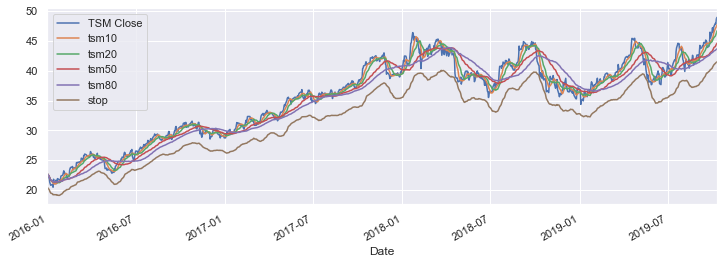

In [39]:
period.plot(y=['TSM Close', 'tsm10', 'tsm20', 'tsm50', 'tsm80', 'stop']);

### Cyclic draw downs as risk measure
We look at the sections between the crossings of 50d and 80d moving averages. We then identify maxima in those sections where the 50d moving average is on top, minima in the others.
Every drop from a maximum to the subsequent minimum is called a cyclic draw down, as is appears at the mean reversion frequency.

In [40]:
diffs = period['tsm50'] - period['tsm80']
d0 = np.sign(diffs)
d = (d0 * d0.shift()).dropna()
d = (1 - d) / 2
d = (d * d0).dropna()

sections = period.copy()

up = d.where(d == 1)
up = up * sections['tsm50']

down = d.where(d == -1)
down = - down * sections['tsm50']

ups = sections['TSM Close'].where(up > 0 ).dropna().keys()
downs = sections['TSM Close'].where(down > 0 ).dropna().keys()

n = max(len(ups), len(downs)) - 1

sections['high'] = np.nan
sections['low'] = np.nan

for i in range(n):
    h = ups[i]
    l = downs[i]
    h1 = ups[i+1]

    section = sections['TSM Close'][h:l]
    local_max = np.max(section)
    
    pos = section.where(section==local_max)
    pos_t = pos.dropna().keys()[0]
    sections['high'][pos_t] = sections['TSM Close'][pos_t]    
    
    section = sections['TSM Close'][l:h1]
    local_min = np.min(section)

    pos = section.where(section==local_min)
    pos_t = pos.dropna().keys()[0]
    sections['low'][pos_t] = sections['TSM Close'][pos_t]    
    

[(Timestamp('2016-03-30 00:00:00'), -0.1375661375661376),
 (Timestamp('2016-10-25 00:00:00'), -0.08906497622820926),
 (Timestamp('2017-06-08 00:00:00'), -0.04045614987781686),
 (Timestamp('2017-11-24 00:00:00'), -0.0939753431030472),
 (Timestamp('2018-01-26 00:00:00'), -0.07217847769028865),
 (Timestamp('2018-04-12 00:00:00'), -0.19019384264538206),
 (Timestamp('2018-09-24 00:00:00'), -0.23457340164847407),
 (Timestamp('2019-04-23 00:00:00'), -0.17084984588287108)]

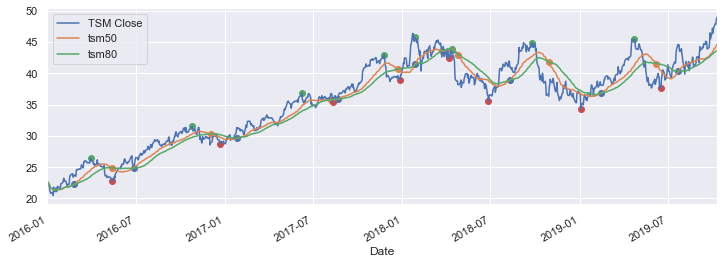

In [41]:
sections.plot(y=['TSM Close', 'tsm50', 'tsm80'])
plt.scatter(x=up.index, y=up.to_numpy())
plt.scatter(x=down.index, y=down.to_numpy())
plt.scatter(x=up.index, y=sections['high'])
plt.scatter(x=up.index, y=sections['low']);

drops = (sections['low'].dropna().to_numpy() - sections['high'].dropna().to_numpy()) / sections['high'].dropna().to_numpy()
highs = sections['high'].dropna().index.to_list()
list(zip(highs, drops))

### std dev w/r/t the rolling average
The following chart helps us to calculate the expected worst case movement of the stock price w/r/t the time passed. E.g.: The std dev from the 20d moving average is about 1.35 Dollar. A multiple of this value can be used as a down fall risk measure.

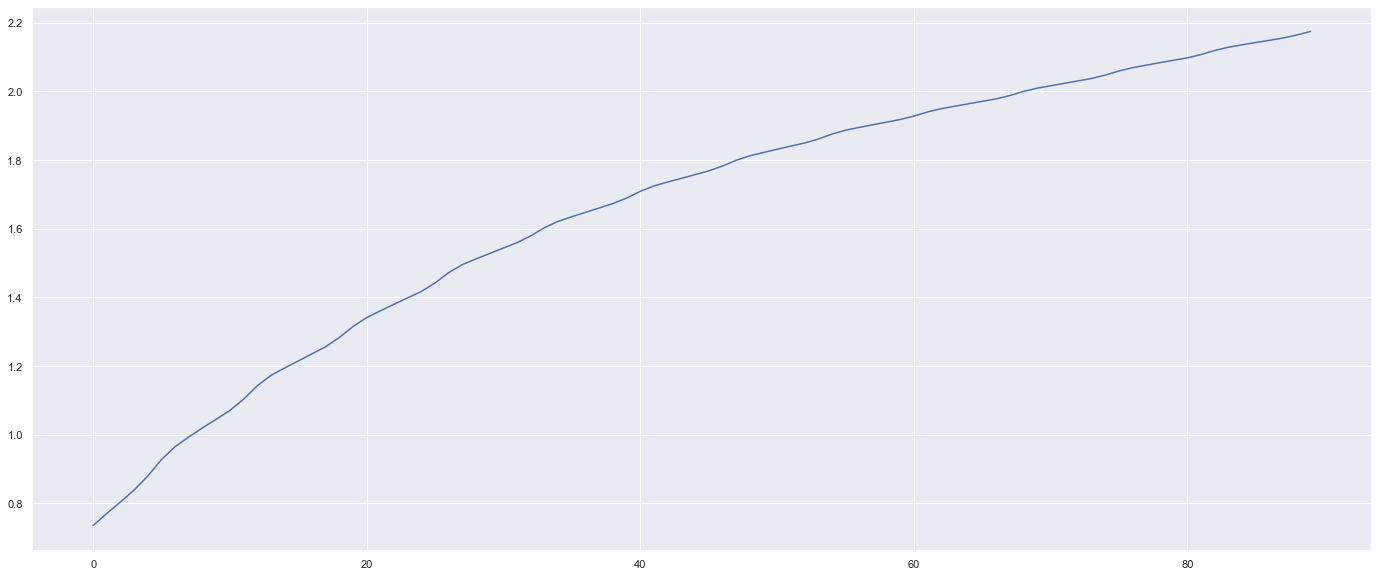

In [19]:
stddevs = [ (period.rolling("%sd" % d).mean()['TSM Close'] - period['TSM Close']).std() for d in range(10, 100)]
plt.plot(stddevs);

In [149]:
delta = tsm.iloc[0]['Close'] - tsm.iloc[0]['Sector']
tsm['shifted'] = tsm['Close'] - delta 

In [138]:
close_rel = np.log((tsm['Close'] / tsm['Close'].shift()).dropna()) * 100

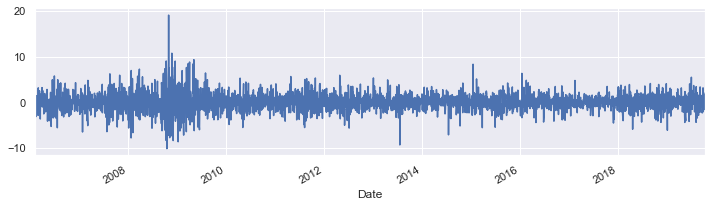

In [173]:
close_rel.plot();